### Анализ данных в задаче кредитного скоринга

In [1]:
import numpy as np
import pandas as pd
import scipy

In [2]:
from scipy import stats
from statsmodels.stats import weightstats
from statsmodels.stats.proportion import proportion_confint

%matplotlib inline
import matplotlib.pyplot as plt
%pylab inline
import itertools

Populating the interactive namespace from numpy and matplotlib


Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

    LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
    SEX: пол клиента (1 = мужской, 2 = женский )
    EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
    MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
    AGE: возраст в годах
    PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
    BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
    PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
    default - индикатор невозврата денежных средств

### Review criteria

    Выполнение каждого пункта задания должно начинаться с графика с данными, которые вы собираетесь анализировать. Еще лучше, если вы разложите графики анализируемого фактора по переменной (default), на которую хотите изучить влияние этого фактора, и проинтерпретируете отличия в полученных распределениях.
    При использовании статистических критериев необходимо убедиться в том, что условия их применимости выполняются. Например, если вы видите, что данные бинарные, то не нужно применять критерий Стьюдента.
    При каждом использовании любого критерия необходимо указать, какая проверяется гипотеза, против какой альтернативы, чему равен достигаемый уровень значимости, принимается или отвергается нулевая гипотеза на уровне значимости 0.05. Если задача позволяет, нужно оценить размер эффекта и предположить, имеет ли этот результат практическую значимость. 

In [3]:
data = pd.read_csv('credit_card_default_analysis.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### 1

Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: 

### a) 
о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки 

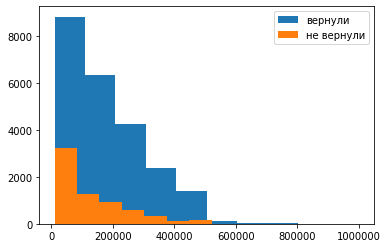

In [4]:
plt.hist(data['LIMIT_BAL'].loc[data.default == 0], label='вернули')
plt.hist(data['LIMIT_BAL'].loc[data.default == 1], label='не вернули')
plt.legend()

In [5]:
lim_bal_0 = data['LIMIT_BAL'].loc[data.default == 0].values
lim_bal_1 = data['LIMIT_BAL'].loc[data.default == 1].values
lim_bal_0.shape, lim_bal_1.shape

((23364,), (6636,))

In [6]:
print('median 0:', np.around(np.median(lim_bal_0),4), '\n', 'median 1:', np.around(np.median(lim_bal_1), 4))

median 0: 150000.0 
 median 1: 90000.0


В принципе, видно невооруженным глазом, но построим интервальную оценку медиан бутсрепом. 

In [7]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [8]:
b_median_0 = list(map(np.median, get_bootstrap_samples(lim_bal_0)))
b_median_1 = list(map(np.median, get_bootstrap_samples(lim_bal_1)))

In [9]:
print('интервальная оценка медиан кредитных лимитов для вернувших:', stat_intervals(b_median_0))
print('интервальная оценка медиан кредитных лимитов для не вернувших:', stat_intervals(b_median_1))

интервальная оценка медиан кредитных лимитов для вернувших: [150000. 150000.]
интервальная оценка медиан кредитных лимитов для не вернувших: [80000. 90000.]


### b) 
о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 

Н0 - распределения равны

Н1 - Н0 не верна

_перестановочный критерий

In [10]:
# да здравствует копирование из лекций

def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = 1000):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), list(filter(lambda i: i not in index, range(n)))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = 1000, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [11]:
p_val = permutation_test(lim_bal_0, lim_bal_1)

In [12]:
print('p-value:', p_val)

p-value: 0.001


Гипотезу о равенстве распределений можно с уверенностью отбросить по результатам.

Из практических вариантов - банк явно выдаёт больший кредитный лимит клиентам с некими параметрами, которых считает более надежными. И это оправдывается, так что можно выдать премию придумавшим модель.

### Пол (SEX): 

Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия) 

Н0 - состав одинаков

Н1 - различен

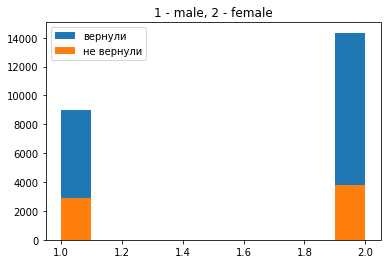

In [13]:
plt.title('1 - male, 2 - female')
plt.hist(data.SEX.loc[data.default == 0], label='вернули')
plt.hist(data.SEX.loc[data.default == 1], label='не вернули')
plt.legend()

In [14]:
def_0_sex = data['SEX'].loc[data.default == 0].values
def_1_sex = data['SEX'].loc[data.default == 1].values
def_0_sex.shape, def_1_sex.shape

((23364,), (6636,))

In [15]:
def_0_sex = np.where(def_0_sex == 1, 1, 0)
def_1_sex = np.where(def_1_sex == 1, 1, 0)
# женский пол теперь 0

In [16]:
m_return = sum(def_0_sex) / len(def_0_sex)
m_not_return = sum(def_1_sex) / len(def_1_sex)
print('доля мужчин в вернувших и не вернувших кредиты:', np.around(m_return, 4) * 100, '% и ', np.around(m_not_return, 4) * 100, '%')

доля мужчин в вернувших и не вернувших кредиты: 38.59 % и  43.29 %


но построим доверительные интервалы 

In [17]:
conf_interval_def_0 = proportion_confint(sum(def_0_sex), 
                                            len(def_0_sex),
                                            method = 'wilson')
conf_interval_def_1 = proportion_confint(sum(def_1_sex), 
                                            len(def_1_sex),
                                            method = 'wilson')

In [18]:
print('интервал для пропорции мужчин в вернувших', np.around(conf_interval_def_0, 4))
print('в невернувших', np.around(conf_interval_def_1, 4))

интервал для пропорции мужчин в вернувших [0.3796 0.3921]
в невернувших [0.4211 0.4449]


интервалы даже не пересекаются, т.е. пропорции полового состава различны

In [19]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [20]:
print("confidence interval: [%f, %f]" % proportions_confint_diff_ind(def_0_sex, def_1_sex))

confidence interval: [-0.060548, -0.033635]


In [21]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = sum(sample1) / n1
    p2 = sum(sample2) / n2
    P = (p1*n1 + p2*n2) / (n1 + n2)
    s = np.sqrt(P * (1 - P) * (1 / n1 + 1 / n2))
    return (p1 - p2) / s

def proportions_diff_z_test(z_stat, alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [22]:
print('p-value:', proportions_diff_z_test(proportions_diff_z_stat_ind(def_1_sex, def_0_sex)))

p-value: 4.472866521609831e-12


разница интервалов на обоих концах отрицательна, а p-value на z-критерии для двух независимых выборок уверенно стремится к нулю, т.е. гипотезу о равенстве отношений полового составе можно отбросить с удвоенной уверенностью.

практическая польза - мужчина скорее, чем женщина, не отдаст кредит, можно добавить штрафной коэф.

### 3

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ? 

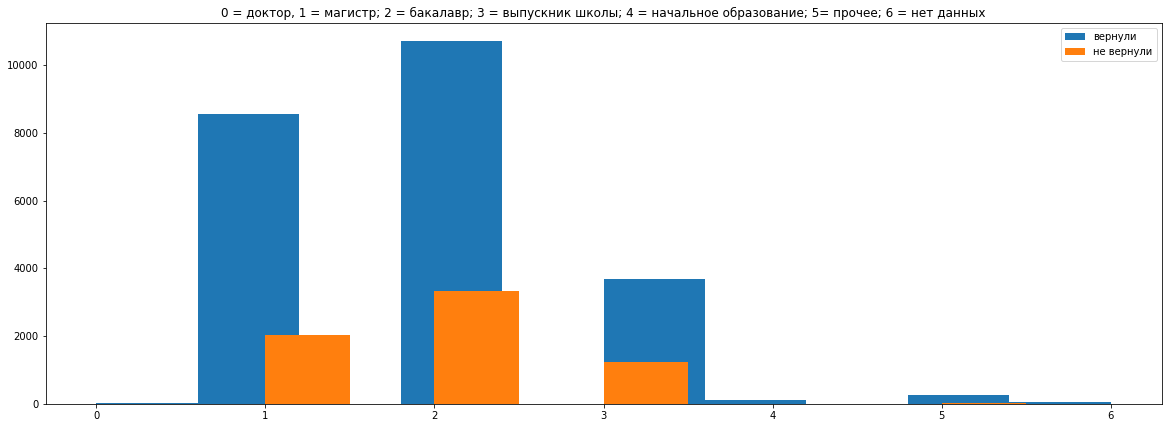

In [23]:
plt.figure(figsize=(20,7))
plt.title('0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных')
plt.hist(data.EDUCATION.loc[data.default == 0], label='вернули')
plt.hist(data.EDUCATION.loc[data.default == 1], label='не вернули')
plt.legend()

как видно, берут кредиты в основном люди с определенным образование и не возвращают их тоже они же (если у вас нет кредита, то вам его не отдавать)

Чтобы построить таблицу сопряженности и при этом сохранить масштаб, сделаем её в долях. переменная "образование" - категориальная, обобщенный хи-квадрат

у нас у 51 человека из 30000 нет данных по образованию, т.е. они входят в одну из категорий и их мало (0.17%), их можно отбросить как выброс

In [24]:
ed_0_1 = pd.DataFrame(np.array(pd.pivot_table(data, values=['SEX'], index=['default'], columns=['EDUCATION'], \
               fill_value = 0, aggfunc='count' )))
ed_0_1 = ed_0_1.drop([6], axis=1)
ed_0_1.loc['2'] = ed_0_1.sum()

ed_0_1

,0,1,2,3,4,5
0,14,8549,10700,3680,116,262
1,0,2036,3330,1237,7,18
2,14,10585,14030,4917,123,280


соотношение по вернувшим / невернувшим по уровню образования, т.е. вероятность, что отдали / не отдали

In [25]:
ed2_0_1 = np.array(ed_0_1.copy())
ed2_0_1 = ed2_0_1[0:2] / ed2_0_1[2]
pd.DataFrame(ed2_0_1)

,0,1,2,3,4,5
0,1.0,0.807652,0.762651,0.748424,0.943089,0.935714
1,0.0,0.192348,0.237349,0.251576,0.056911,0.064286


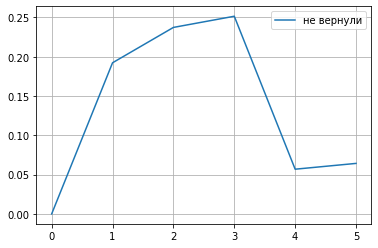

In [26]:
plt.plot(range(0,6), ed2_0_1[1], label='не вернули')
plt.legend()
plt.grid()

Это эксперимент с исходом {0,1}, имеет кол-во удачных исходов из всех. Проверяем гипотезу, что эта величина из  биномиального распределения.

In [27]:
p_binom = ed2_0_1[1]
n_binom = np.array(ed_0_1.iloc[2])
k_binom = np.array(ed_0_1.iloc[1])

In [28]:
expected_frequencies = np.zeros(6)
for i in range(6):
    expected_frequencies[i] = stats.binom.pmf(k_binom[i], n_binom[i], p_binom[i])
    
expected_frequencies

array([1.        , 0.00983763, 0.00791614, 0.01311051, 0.15342643,
       0.09675711])

In [29]:
observed_frequences = ed2_0_1[1]
observed_frequences

array([0.        , 0.19234766, 0.23734854, 0.25157616, 0.05691057,
       0.06428571])

требуемая таблица сопряженности - разность между expected_frequencies и observed_frequences и аналогично составленная для тех, кто кредиты отдали.

In [30]:
observed_frequences - expected_frequencies

array([-1.        ,  0.18251003,  0.2294324 ,  0.23846565, -0.09651586,
       -0.0324714 ])

Проверка критерием согласия, H0 - наши невозвраты имеют биномиальное распределение

In [31]:
stats.chisquare(observed_frequences, expected_frequencies, ddof=0)

Power_divergenceResult(statistic=15.444619420132417, pvalue=0.008622259918208624)

In [32]:
data.EDUCATION.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

p-value мало и эту гипотезу можно отбросить. вместе с ней идею (в связи с большим n) и нормальное, и бернулли, и пуассона. а значит, предугадать относительно простыми методами % невозвратов по образованию нельзя. можно только сказать, что люди с самым распространным образованием (школьное + бакалавр + магистр), которые берут подавляющее большинство кредитов их чаще всего и не возвращают (хотя опаснее всего бакалавр). а те 1,56 %, которые составляют люди с другим образованием, погоды не делают. 

### 4

Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

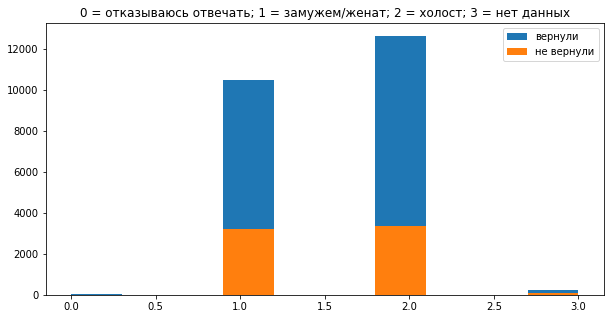

In [33]:
plt.figure(figsize=(10,5))
plt.title('0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных')
plt.hist(data.MARRIAGE.loc[data.default == 0], label='вернули')
plt.hist(data.MARRIAGE.loc[data.default == 1], label='не вернули')
plt.legend()

In [34]:
data.MARRIAGE.value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

выбрасываем 1,2% тех, кто отказался отвечать или нет данных, тогда у нас получится красивая пара бинарных данных и можно применить корреляцию метьюса

In [35]:
mer_0_1 = pd.DataFrame(np.array(pd.pivot_table(data, values=['SEX'], index=['default'], columns=['MARRIAGE'], \
               fill_value = 0, aggfunc='count' ))).drop([0, 3], axis=1)
mer_0_1

,1,2
0,10453,12623
1,3206,3341


In [36]:
mer = np.array(mer_0_1)
a = mer[0][0]
b = mer[0][1]
c = mer[1][0]
d = mer[1][1]
a, b, c, d

(10453, 12623, 3206, 3341)

In [37]:
mcc = (a * d - c * d) / np.sqrt((a+b)*(a+c)*(b+d)*(c+d))
mcc

0.13339912756311206

корреляция между величинами согласно корреляции метьюса присутствует, хотя и не очень сильная. но и не нулевая. практически это значит, что семейные люди чуть чаще, чем одиночки, возвращают кредиты, хотя этот признак не такой уж и сильный. впрочем, сильнее образования.

### 5

Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

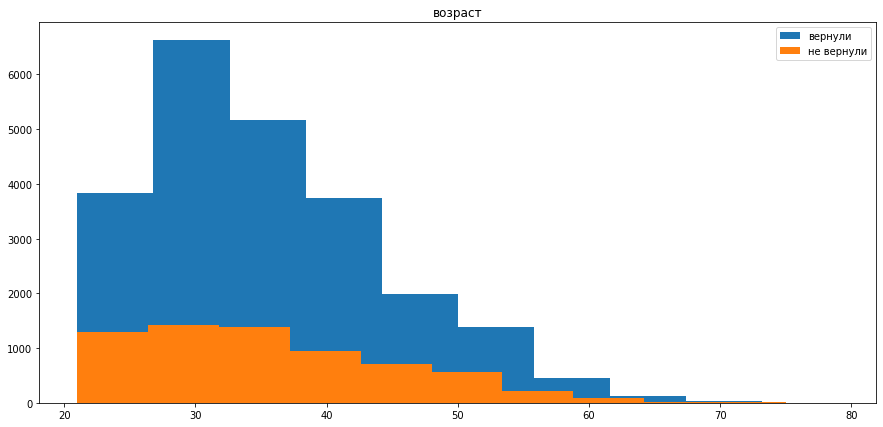

In [38]:
plt.figure(figsize=(15,7))
plt.title('возраст')
plt.hist(data.AGE.loc[data.default == 0], label='вернули')
plt.hist(data.AGE.loc[data.default == 1], label='не вернули')
plt.legend()

### медианы

Н0 медианы равны

Н1 медианы отличаются

Бутстрап

In [39]:
# точечная оценка
print('медиана для вернувших', data.AGE.loc[data.default == 0].median())
print('медиана для не вернувших', data.AGE.loc[data.default == 1].median())

медиана для вернувших 34.0
медиана для не вернувших 34.0


In [40]:
age_0 = data['AGE'].loc[data.default == 0].values
age_1 = data['AGE'].loc[data.default == 1].values
age_0.shape, age_1.shape

((23364,), (6636,))

In [41]:
age_median_0 = list(map(np.median, get_bootstrap_samples(age_0)))
age_median_1 = list(map(np.median, get_bootstrap_samples(age_1)))

In [42]:
print('интервальная оценка медиан кредитных лимитов для вернувших:', stat_intervals(age_median_0))
print('интервальная оценка медиан кредитных лимитов для не вернувших:', stat_intervals(age_median_1))

интервальная оценка медиан кредитных лимитов для вернувших: [34. 34.]
интервальная оценка медиан кредитных лимитов для не вернувших: [34. 35.]


интервалы пересекаются, отвергнуть Н0 нельзя

In [43]:
print('оценка пересечения интервалов', stat_intervals(list(np.array(age_median_0) - np.array(age_median_1))))

оценка пересечения интервалов [-1.  0.]


0 входит в интервал - отвергнуть не можем

#### подходящий непараметрический критерий

уже использованный перестановочный критерий

H0 - распределения равны

In [44]:
print('p-value:', permutation_test(age_0, age_1))

p-value: 0.021


равенство распределений отвергнуто, что и было видно на графиках. с практической точки зрения изучать средний или медианный возраст действительно смысла нет. имеет смысл смотреть на группы по возрастам.